# PyTrilinos2 tutorial

We will use the Python interface of Trilinos (PyTrilinos2) to set up and solve a linear system (using Tpetra and Thyra) using different linear solvers and preconditioners from Amesos2, Belos, Ifpack2 and MueLu.

We first set up a MPI communicator and an output stream. The MPI communicator has size 1 for now.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# get C-level cout to display
%load_ext wurlitzer

In [2]:
from mpi4py import MPI
from PyTrilinos2 import Teuchos

comm = Teuchos.getTeuchosComm(MPI.COMM_WORLD)
out = Teuchos.fancyOStream(Teuchos.getCout())
print("Comm size", comm.getSize())

Comm size 1


The Tpetra package provides sparse linear algebra.

In [3]:
from PyTrilinos2 import Tpetra

Tpetra linear algebra classes are templated on
- scalar type, e.g. `double`, `float`, `std::complex<double>`
- local ordinal type, normally `int`
- global ordinal type, normally `long long`
- node type, a combination of a Kokkos execution space and memory space.
  
Python does not have templates, so templated classes are exposed with template parameters as suffixes:

In [4]:
Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

Since that's not very convenient (and differs from C++) we have some helper classes:

In [5]:
Tpetra.Map['int', 'long long', 'serial']

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

We can leverage default values for template arguments to further simplify:

In [6]:
Tpetra.Map['int']

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

In [7]:
Tpetra.Map[()]  # no arguments specified, note ()

PyTrilinos2.PyTrilinos2.Tpetra.Map_int_long_long_Tpetra_KokkosCompat_KokkosDeviceWrapperNode_Kokkos_Serial_t

We set up a linear system
$$A x = b$$

In [8]:
def assemble1DLaplacian(rowmap):
    from PyTrilinos2 import Tpetra

    A = Tpetra.CrsMatrix[()](rowmap, 3)
    for lid in range(rowmap.getMinLocalIndex(), rowmap.getMaxLocalIndex()+1):
        gid = rowmap.getGlobalElement(lid)
        indices = [gid]
        vals = [2.]
        if gid > 0:
            indices.append(gid-1)
            vals.append(-1.)
        if gid < rowmap.getMaxAllGlobalIndex():
            indices.append(gid+1)
            vals.append(-1.)
        A.insertGlobalValues(gid, indices, vals)
    A.fillComplete()
    return A

numRows = 1000
tpetra_map = Tpetra.Map[()](numGlobalElements=numRows, numLocalElements=numRows, indexBase=0, comm=comm)    
tpetra_A = assemble1DLaplacian(tpetra_map)

tpetra_b = Tpetra.Vector['double'](tpetra_A.getRangeMap())
tpetra_x = Tpetra.Vector['double'](tpetra_A.getDomainMap())
tpetra_b.putScalar(1.0)
tpetra_x.putScalar(0.0)

# compute the residual and check that x does not solve the system already
tpetra_residual = Tpetra.Vector['double'](tpetra_A.getRangeMap())
tpetra_A.apply(tpetra_x, tpetra_residual)
tpetra_residual.update(1.0, tpetra_b, -1.0)
print(r'|Ax-b|_2 =', tpetra_residual.norm2())

|Ax-b|_2 = 31.622776601683793


We want to solve for $x$. 
Trilinos provides
- direct solvers in the package Amesos2,
- Krylov solvers in Belos,
- simple preconditioners and incomplete factorizations in Ifpack2,
- algebraic multigrid in MueLu,
- and more.

Trilinos has a unified solver/preconditioner interface (Stratimikos).
We will wrap our linear algebra objects from Tpetra to Thyra so that Stratimikos can use them.

In [9]:
from PyTrilinos2 import Thyra


def toThyra(obj):
    if isinstance(obj, Tpetra.Map.templatedClasses):
        return Thyra.tpetraVectorSpace(obj)
    elif isinstance(obj, Tpetra.Vector.templatedClasses):
        thyra_map = toThyra(obj.getMap())
        return Thyra.tpetraVector(thyra_map, obj)
    elif isinstance(obj, Tpetra.MultiVector.templatedClasses):
        thyra_map = toThyra(obj.getMap())
        return Thyra.tpetraMultiVector(thyra_map, obj)
    elif isinstance(obj, Tpetra.CrsMatrix.templatedClasses):
        thyra_domainmap = toThyra(obj.getDomainMap())
        thyra_rangemap = toThyra(obj.getRangeMap())
        return Thyra.tpetraLinearOp(thyra_rangemap, thyra_domainmap, obj)
    else:
        raise NotImplementedError(type(obj))

thyra_x = toThyra(tpetra_x)
thyra_b = toThyra(tpetra_b)
thyra_A = toThyra(tpetra_A)

Now we can set up the linear solver builder:

In [10]:
from PyTrilinos2 import Stratimikos

linearSolverBuilder = Stratimikos.LinearSolverBuilder['double']()

We set parameters as a Teuchos ParameterList which is similar to a Python dictionary. "Amesos2" will give us a direct solver.

In [11]:
params = Teuchos.ParameterList()
params["Linear Solver Type"] = "Amesos2"
print(params)

Linear Solver Type = Amesos2   [unused]



In [12]:
linearSolverBuilder.setParameterList(params)
solverFactory = Thyra.createLinearSolveStrategy(linearSolverBuilder)
thyra_invA = Thyra.linearOpWithSolve(solverFactory, thyra_A)

We can now solve the linear system:

In [13]:
status = thyra_invA.solve(Thyra.NOTRANS, thyra_b, thyra_x)
status.solveStatus

<ESolveStatus.SOLVE_STATUS_CONVERGED: 0>

We check the result:

In [14]:
tpetra_A.apply(tpetra_x, tpetra_residual)
tpetra_residual.update(1.0, tpetra_b, -1.0)
print(r'|Ax-b|_2 =', tpetra_residual.norm2())

|Ax-b|_2 = 2.965272890640642e-10


Print default parameters

In [15]:
print(linearSolverBuilder.getValidParameters())

Linear Solver Type = Belos   [unused]
Preconditioner Type = Ifpack2   [unused]
Enable Delayed Solver Construction = 0   [unused]
Linear Solver Types -> 
 Amesos2 -> 
  Solver Type = KLU2   [unused]
  Refactorization Policy = RepivotOnRefactorization   [unused]
  Throw on Preconditioner Input = 1   [unused]
  VerboseObject -> 
   Verbosity Level = default   [unused]
   Output File = none   [unused]
 Belos -> 
  Solver Type = Pseudo Block GMRES   [unused]
  Convergence Test Frequency = 1   [unused]
  Left Preconditioner If Unspecified = 0   [unused]
  Solver Types -> 
   Block GMRES -> 
    Convergence Tolerance = 1e-08   [unused]
    Maximum Restarts = 20   [unused]
    Maximum Iterations = 1000   [unused]
    Num Blocks = 300   [unused]
    Block Size = 1   [unused]
    Adaptive Block Size = 1   [unused]
    Verbosity = 0   [unused]
    Output Style = 0   [unused]
    Output Frequency = -1   [unused]
    Output Stream = Teuchos::RCP<std::ostream>{ptr=0x7f7a990da580,node=0x20a39030,stro

In [16]:
Stratimikos.enableMueLu(linearSolverBuilder, "MueLu")

In [17]:
params = Teuchos.ParameterList()
params["Preconditioner Type"] = "MueLu"
linearSolverBuilder.setParameterList(params)
solverName = linearSolverBuilder.getLinearSolveStrategyName()
precName = linearSolverBuilder.getPreconditionerStrategyName()
solverFactory = Thyra.createLinearSolveStrategy(linearSolverBuilder)
solverName, precName

('Belos', 'MueLu')

In [18]:
thyra_invA = Thyra.linearOpWithSolve(solverFactory, thyra_A)

In [19]:
status = thyra_invA.solve(Thyra.NOTRANS, thyra_b, thyra_x)
status.message

'The Belos solver "Belos" of type ""Belos::PseudoBlockGmresSolMgr": {Num Blocks: 300, Maximum Iterations: 1000, Maximum Restarts: 20, Convergence Tolerance: 1e-08}" returned a solve status of "SOLVE_STATUS_UNCONVERGED" in 1 iterations with total CPU time of 0.000705077 sec'

In [20]:
tpetra_b.getLocalViewHost()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [21]:
tpetra_x.getLocalViewHost()

array([   500.,    999.,   1497.,   1994.,   2490.,   2985.,   3479.,
         3972.,   4464.,   4955.,   5445.,   5934.,   6422.,   6909.,
         7395.,   7880.,   8364.,   8847.,   9329.,   9810.,  10290.,
        10769.,  11247.,  11724.,  12200.,  12675.,  13149.,  13622.,
        14094.,  14565.,  15035.,  15504.,  15972.,  16439.,  16905.,
        17370.,  17834.,  18297.,  18759.,  19220.,  19680.,  20139.,
        20597.,  21054.,  21510.,  21965.,  22419.,  22872.,  23324.,
        23775.,  24225.,  24674.,  25122.,  25569.,  26015.,  26460.,
        26904.,  27347.,  27789.,  28230.,  28670.,  29109.,  29547.,
        29984.,  30420.,  30855.,  31289.,  31722.,  32154.,  32585.,
        33015.,  33444.,  33872.,  34299.,  34725.,  35150.,  35574.,
        35997.,  36419.,  36840.,  37260.,  37679.,  38097.,  38514.,
        38930.,  39345.,  39759.,  40172.,  40584.,  40995.,  41405.,
        41814.,  42222.,  42629.,  43035.,  43440.,  43844.,  44247.,
        44649.,  450

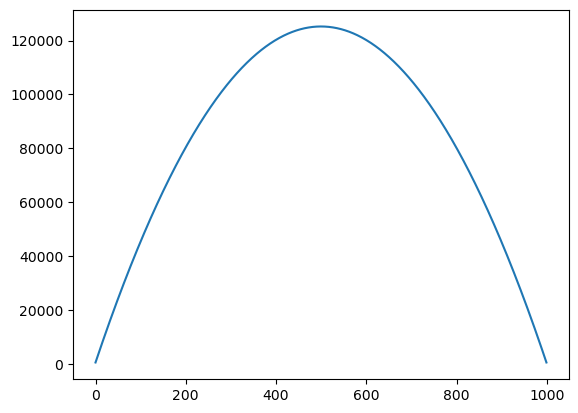

In [22]:
plt.plot(tpetra_x.getLocalViewHost())